<a href="https://colab.research.google.com/github/TetorCo/TetorCo/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) 데이터 선정

**영국 프리미어리그의 팀 별 경기 통계를 가지고서 순위를 예측할 수 있는 지 궁금했기 때문에 이 데이터를 선택하게 되었고, 더 자세한 데이터는 정식 홈페이지에서 웹 크롤링이나 타 사이트에서 돈을 주고서 얻을 수 있었기 때문에 배제를 했습니다**

**순위를 예측하기 위해서 승/무/패를 구별할 수 있게 다중분류의 유형입니다.**

**순위를 예측하기 위해서 승/패(무승부도 패배로 처리)를 구별하는 분류문제 유형입니다.**

**가설: 매치 통계를 보고 결과를 예측할 수 있다.**

**target('Result') : 승/패 예측**

**baseline : 홈 팀의 승률**

**평가지표 : f1_score**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 데이터가 온전한 것만 concat

In [ ]:
path = '/content/drive/MyDrive/Section 2 Project/'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')]

**피처들중에서 target에 심각하게 영향을 줄 수 있는 Goal관련 피처들 삭제**

In [ ]:
# 폴더 안에 있는 csv 파일을 불러와서 전처리
df = pd.DataFrame()
for i in file_list_py:
  data = pd.read_csv(path + i, error_bad_lines=False)
  df = pd.concat([df,data], axis = 0)
  df = df.loc[:, ['HomeTeam', 'AwayTeam', 'FTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC',
       'HY', 'AY', 'HR', 'AR']]
df = df.reset_index(drop=False).drop(columns='index')
df.rename(columns={'FTR': 'Result'}, inplace=True)
df.dropna(inplace=True)

b'Skipping line 305: expected 57 fields, saw 72\nSkipping line 306: expected 57 fields, saw 72\nSkipping line 307: expected 57 fields, saw 72\nSkipping line 308: expected 57 fields, saw 72\nSkipping line 309: expected 57 fields, saw 72\nSkipping line 310: expected 57 fields, saw 72\nSkipping line 311: expected 57 fields, saw 72\nSkipping line 312: expected 57 fields, saw 72\nSkipping line 313: expected 57 fields, saw 72\nSkipping line 314: expected 57 fields, saw 72\nSkipping line 315: expected 57 fields, saw 72\nSkipping line 316: expected 57 fields, saw 72\nSkipping line 317: expected 57 fields, saw 72\nSkipping line 318: expected 57 fields, saw 72\nSkipping line 319: expected 57 fields, saw 72\nSkipping line 320: expected 57 fields, saw 72\nSkipping line 321: expected 57 fields, saw 72\nSkipping line 322: expected 57 fields, saw 72\nSkipping line 323: expected 57 fields, saw 72\nSkipping line 324: expected 57 fields, saw 72\nSkipping line 325: expected 57 fields, saw 72\nSkipping li

In [ ]:
df.isnull().sum()

HomeTeam    0
AwayTeam    0
Result      0
Referee     0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64

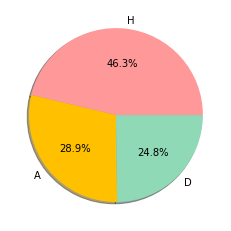

In [ ]:
# target의 분포
colors = ['#ff9999', '#ffc000', '#8fd9b6']
plt.pie(df['Result'].value_counts(), labels=df['Result'].value_counts().index, autopct='%.1f%%', colors=colors, shadow=True);
plt.show()

**데이터가 8:2로 불균형하다는 것을 알 수 있다. 추후에 파라미터 조절할 때 참고**

**baseline은 경기 결과가 승리로 나타내는 0.75이다.**

In [ ]:
df['Result'] = df['Result'].map({'H': 1, 'D': 0, 'A': 2}) # Result를 숫자로 매핑

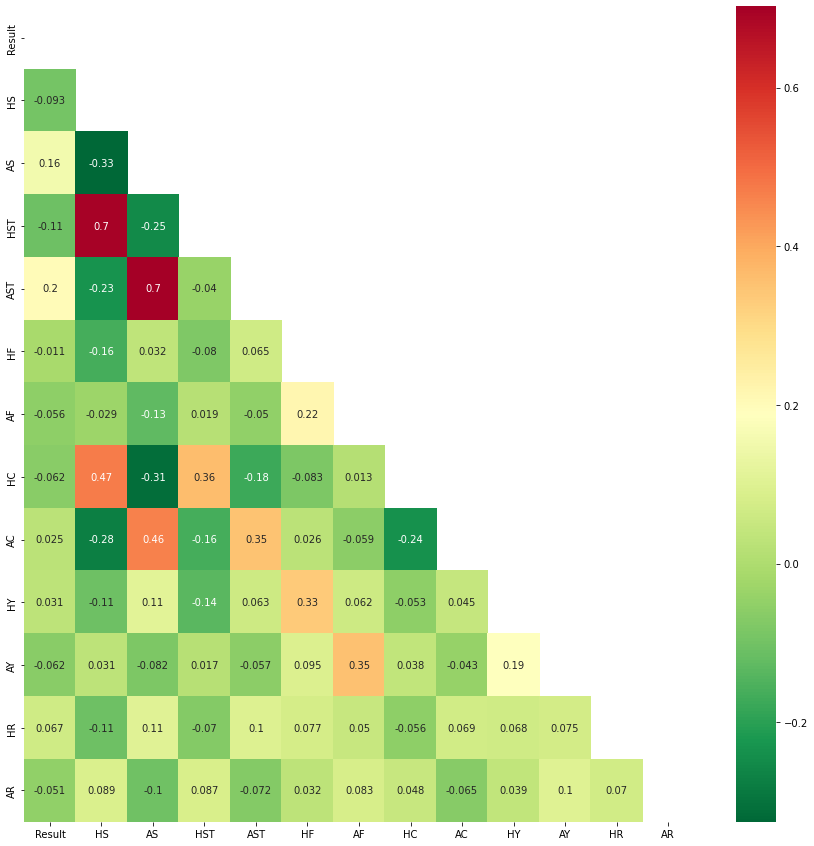

In [98]:
plt.figure(figsize=(15,15))
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), mask=mask, annot=True, cmap='RdYlGn_r');

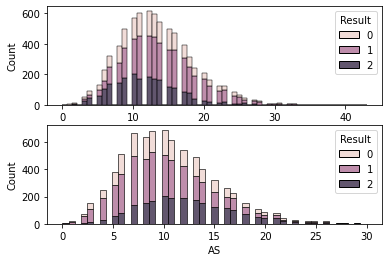

In [99]:
# HS / AS vs Result
plt.subplot(2, 1, 1)
sns.histplot(data=df, x='HS', hue='Result', multiple='stack');

plt.subplot(2,1,2)
sns.histplot(data=df, x='AS', hue='Result', multiple='stack');

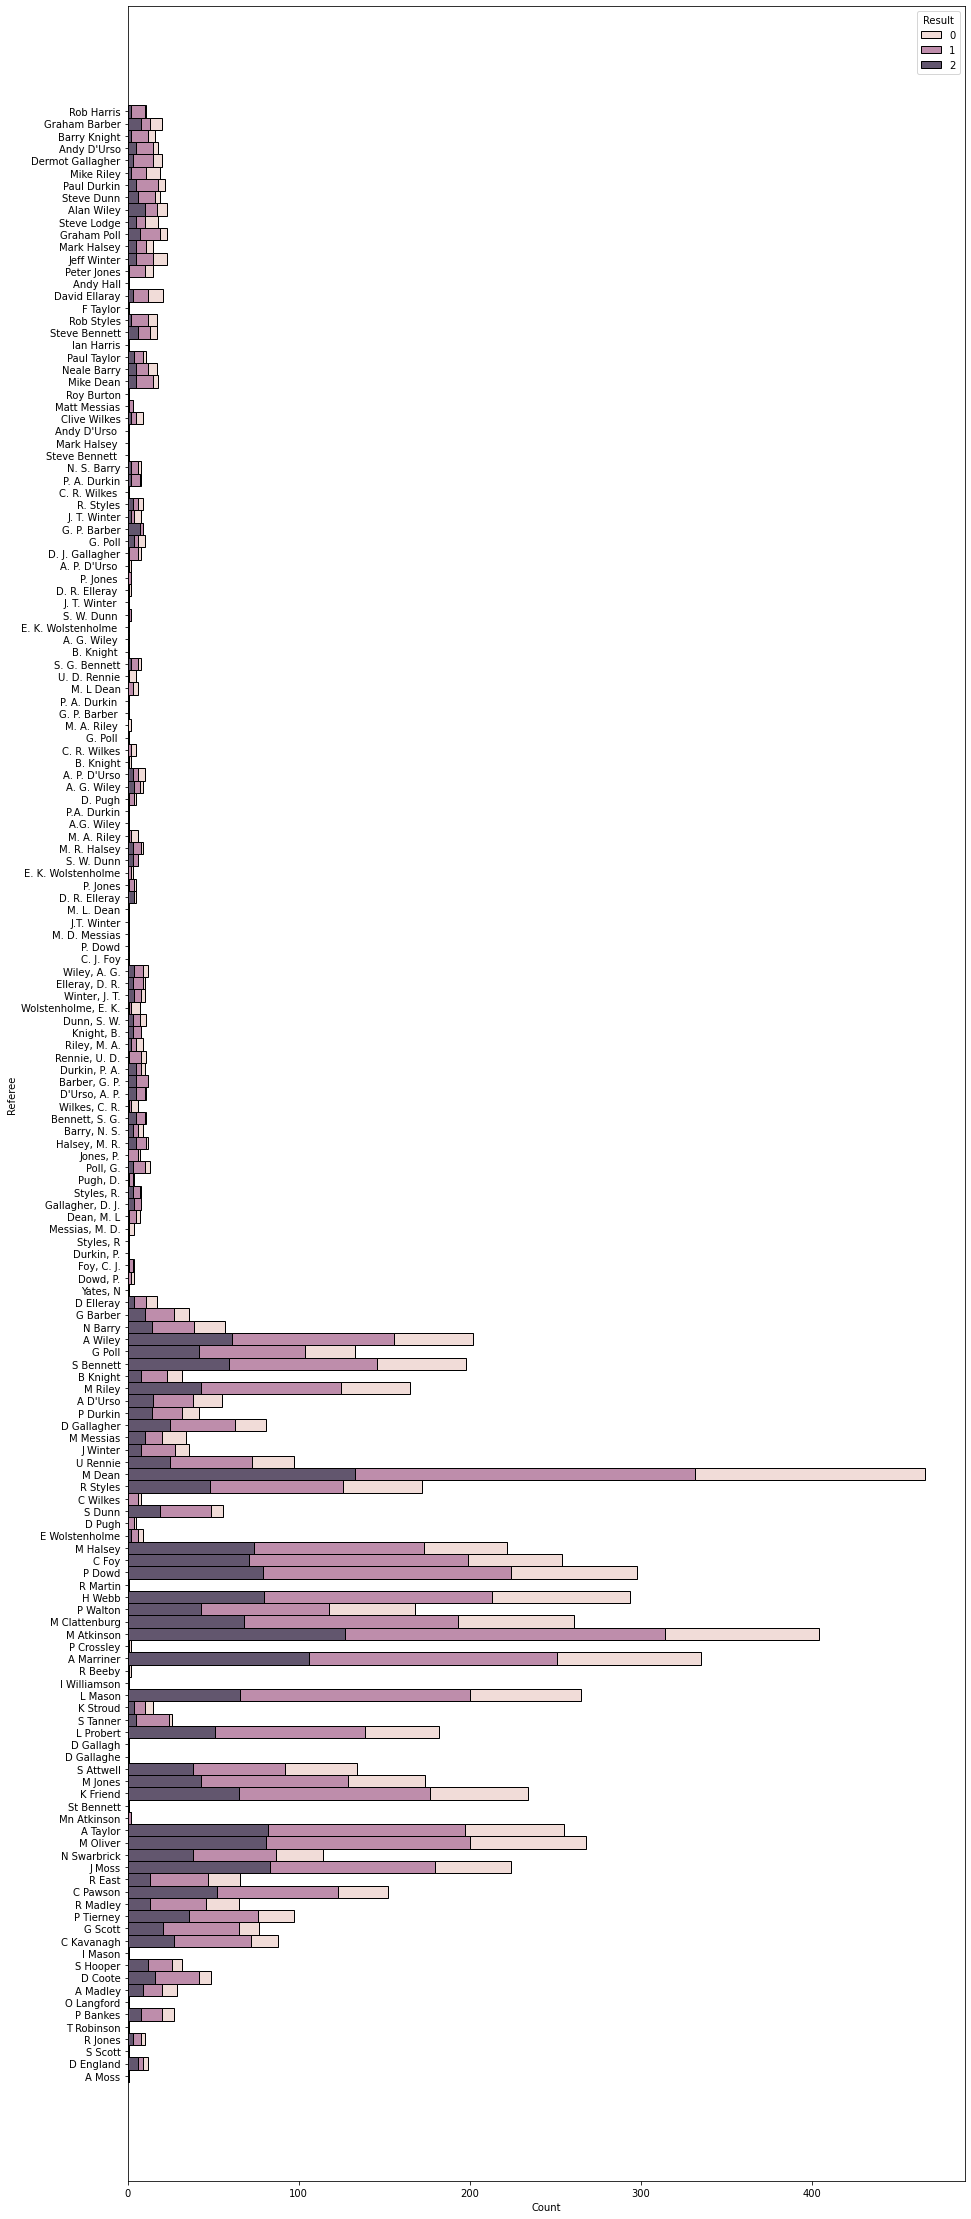

In [ ]:
plt.figure(figsize=(15,40))
sns.histplot(y='Referee', hue='Result', multiple='stack', data=df)

# test set 만들기

In [ ]:
s1516 = pd.read_csv('/content/drive/MyDrive/15-16.csv')

In [ ]:
def del_col(data):
  data = data.loc[:, ['HomeTeam', 'AwayTeam','FTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC',
       'HY', 'AY', 'HR', 'AR']]
  data.rename(columns={'FTR': 'Result'}, inplace=True)
  data['Result'] = data['Result'].map({'H': 1, 'D': 0, 'A': 2}) # Result를 숫자로 매핑
  return data

In [ ]:
X_test = del_col(s1516).drop(columns='Result')
y_test = del_col(s1516)['Result']

# 모델링하기전에 데이터 분리

In [ ]:
!pip install catboost
!pip install category_encoders

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
target = 'Result'

In [ ]:
X_train = df.drop(target, axis=1)
y_train = df[target]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=7)

In [ ]:
k = KFold(n_splits=5)

# 인코딩 별로 모델 정리

**Decision Tree**

In [ ]:
dt_pipe = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=7, criterion='entropy')
)
dt_model = dt_pipe.fit(X_train, y_train)

In [ ]:
dt_y_pred = dt_model.predict(X_val)
print(accuracy_score(y_val, dt_y_pred))

0.4440894568690096


**RandomForest**

In [ ]:
rfc_pipe = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=7)
)
rfc_model = rfc_pipe.fit(X_train, y_train)

In [ ]:
rfc_y_pred = rfc_model.predict(X_val)
print(accuracy_score(y_val, rfc_y_pred))

0.5410010649627263


**LogisticRegression**

In [ ]:
log_pipe = make_pipeline(
    OrdinalEncoder(),
    LogisticRegression(multi_class='multinomial', random_state=7)
)
log_model = log_pipe.fit(X_train, y_train)

In [ ]:
log_y_pred = log_model.predict(X_val)
print(accuracy_score(y_val, log_y_pred))

0.5473908413205538


# 교차 검증 평균 그래프

**모델들의 교차 검증 평균을 리스트로 만들어서 그래프로 그려준다.**

In [ ]:
random_state=7
classifiers = []
classifiers.append(dt_pipe)
classifiers.append(rfc_pipe)
classifiers.append(log_pipe)

cv_result = []
for classifier in classifiers:
  cv_result.append(cross_val_score(classifier, X_train, y_train, scoring='accuracy', cv=k, n_jobs=1).mean())

In [ ]:
cv_result = pd.DataFrame(cv_result)
cv_result.rename(columns={0: 'CrossValMean'}, index={0: 'DTC',
                                                     1: 'RFC',
                                                     2: 'LOG'}, inplace=True)
cv_result = cv_result.sort_values(by='CrossValMean', ascending=False)

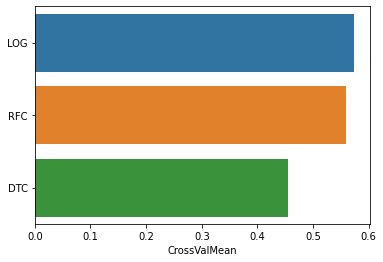

In [ ]:
sns.barplot(data=cv_result, y=cv_result.index, x='CrossValMean');

In [ ]:
cv_result

,CrossValMean
LOG,0.572979
RFC,0.558774
DTC,0.455788


**교차검증의 평균이 제일 높은 것은 Log였고, 결정 트리가 제일 낮았다.**


# 선택한 모델들 하이퍼 파라미터 튜닝

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [90]:
rfc_pipe = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        n_estimators=1500,
        criterion='entropy',
        max_depth=None,
        min_samples_split=6,
        min_samples_leaf=5,
        class_weight='balanced', # 데이터의 불균형
        random_state=7)
)
rfc_model = rfc_pipe.fit(X_train, y_train)

In [91]:
rfc_y_pred = rfc_model.predict(X_val)
print(accuracy_score(y_val, rfc_y_pred))

0.556975505857295


In [92]:
log_pipe = make_pipeline(
    OrdinalEncoder(),
    LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        multi_class='multinomial', random_state=7)
)
log_model = log_pipe.fit(X_train, y_train)

In [93]:
log_y_pred = log_model.predict(X_val)
print(accuracy_score(y_val, log_y_pred))

0.5362087326943556


**랜덤 포레스트로 테스트 세트 학습**

In [ ]:
y_pred = rfc_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.5447368421052632


**모델이 베이스라인보다 훨씬 성능이 떨어졌고, 이유는 데이터가 모델에 학습시키기에는 많이 부족했다고 생각이 들고, 파라미터를 조절하는데 아직 익숙하지가 않아서 모델의 최대 성능을 끌어낼수 없었다.**

# 모델 해석

**순열 중요도**

In [ ]:
! pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 생성
permuter = PermutationImportance(
    rfc_model,
    scoring='accuracy',
    n_iter=10,
    random_state=7
)

# permutation importance 계산
permuter.fit(X_val, y_val)

In [107]:
# 결과 확인
feature_names = list(X_val.columns)
importances = pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)
importances

HST         0.068530
AST         0.037487
AwayTeam    0.022897
HomeTeam    0.020021
HC          0.008839
Referee     0.007721
AC          0.006124
HF          0.004207
AS          0.003355
HR          0.002982
HY          0.002662
AR          0.001012
AY          0.000532
AF         -0.000639
HS         -0.001012
dtype: float64

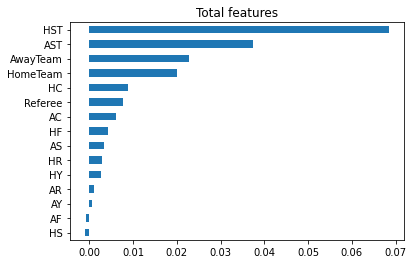

In [111]:
# barplot
plt.title('Total features')
importances.sort_values().plot.barh();

**PDP**

In [ ]:
! pip install pdpbox

In [112]:
from pdpbox.pdp import pdp_isolate, pdp_plot

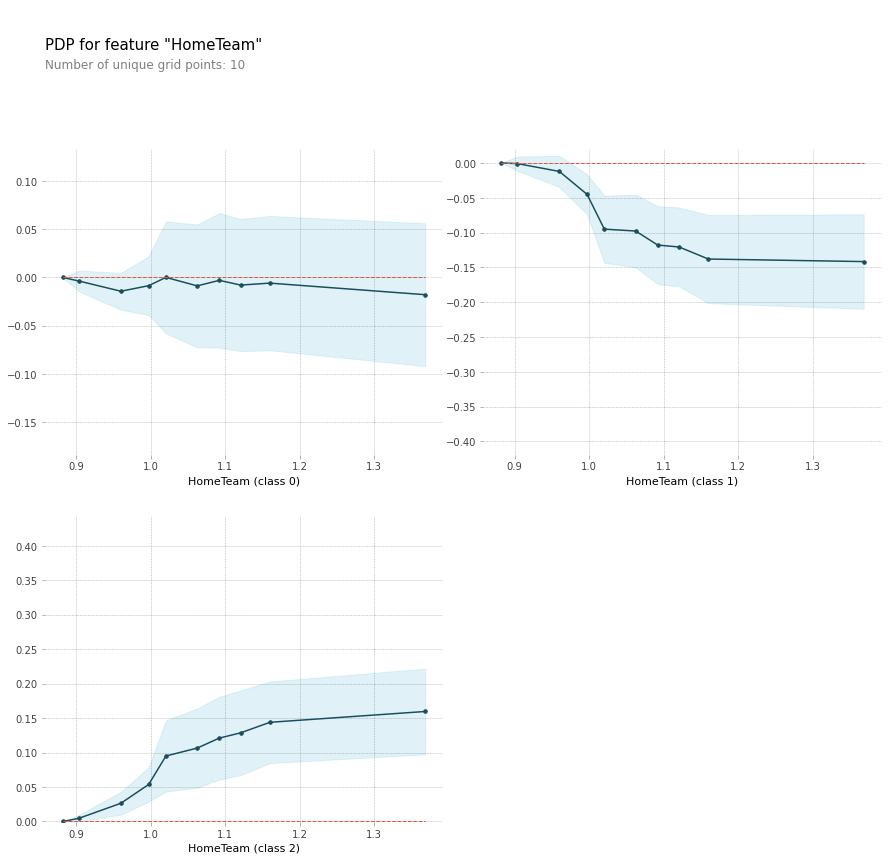

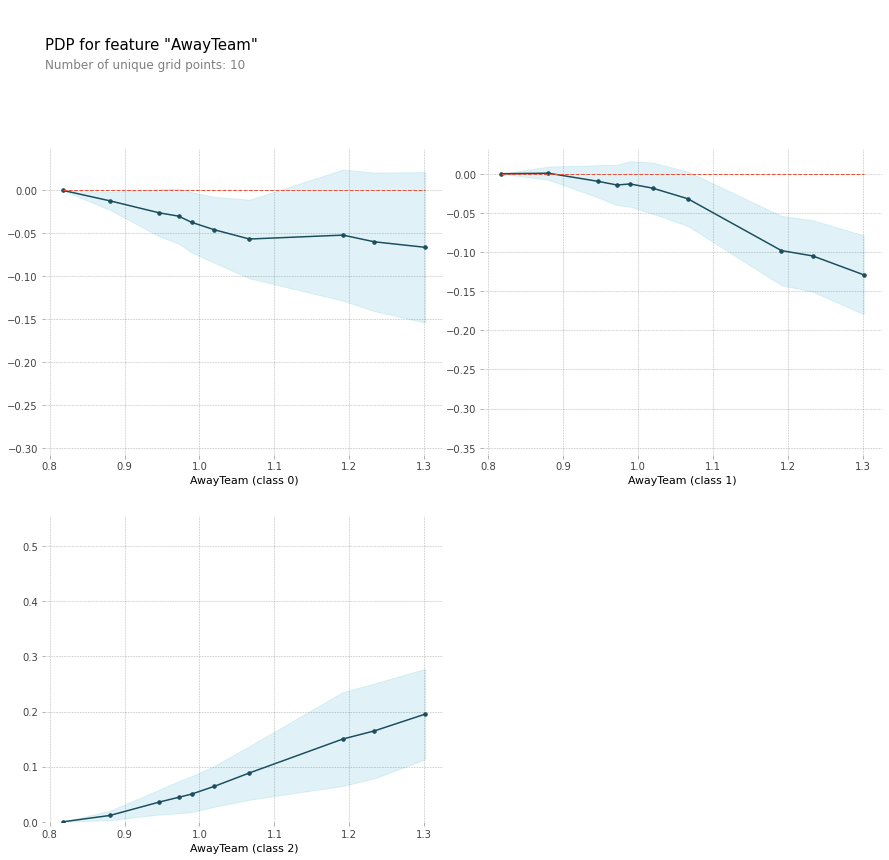

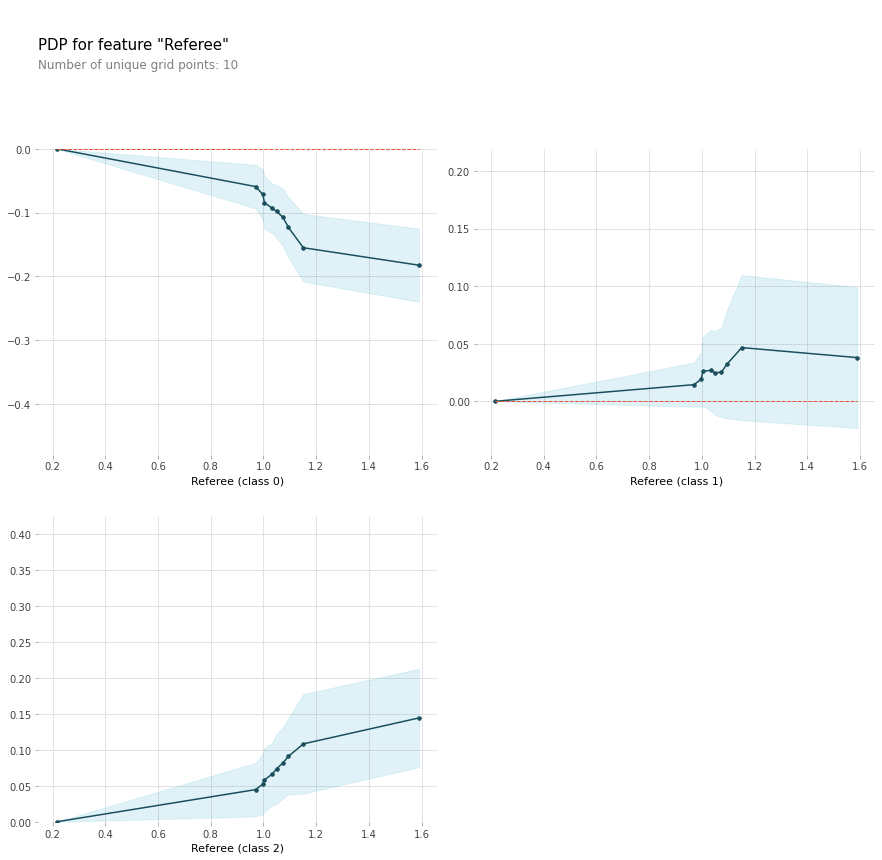

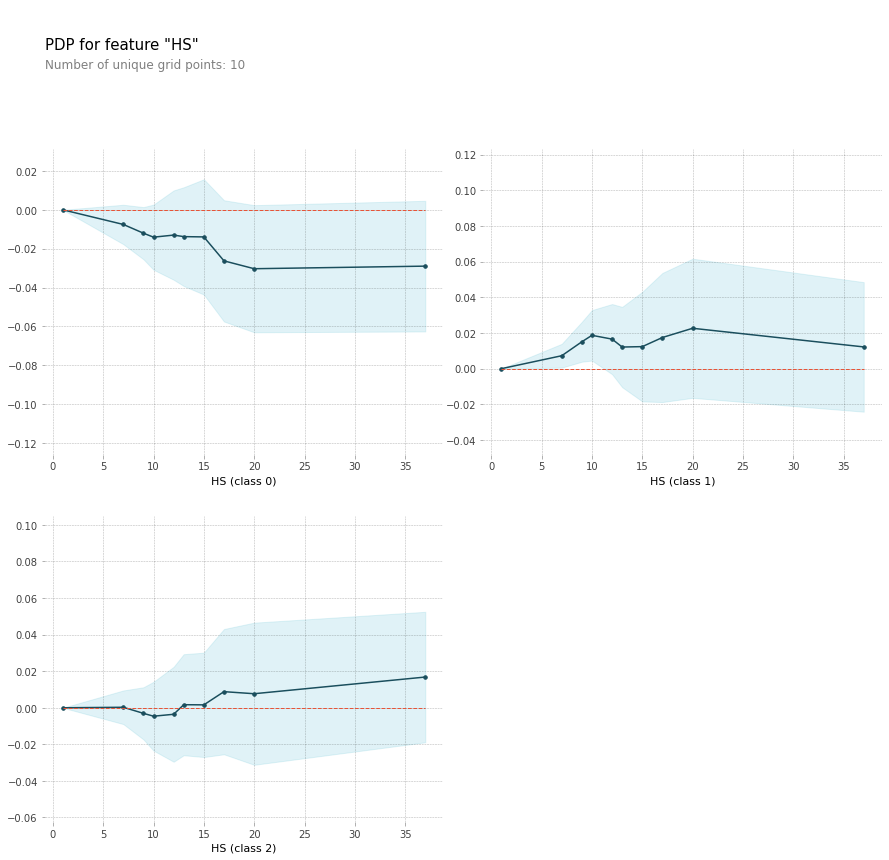

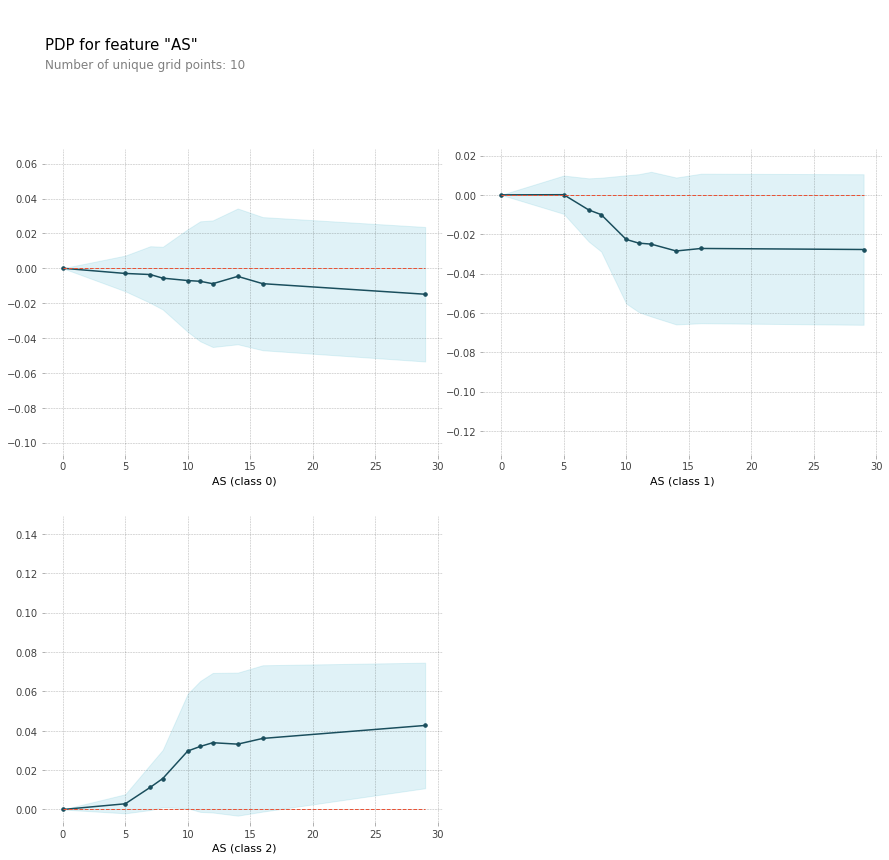

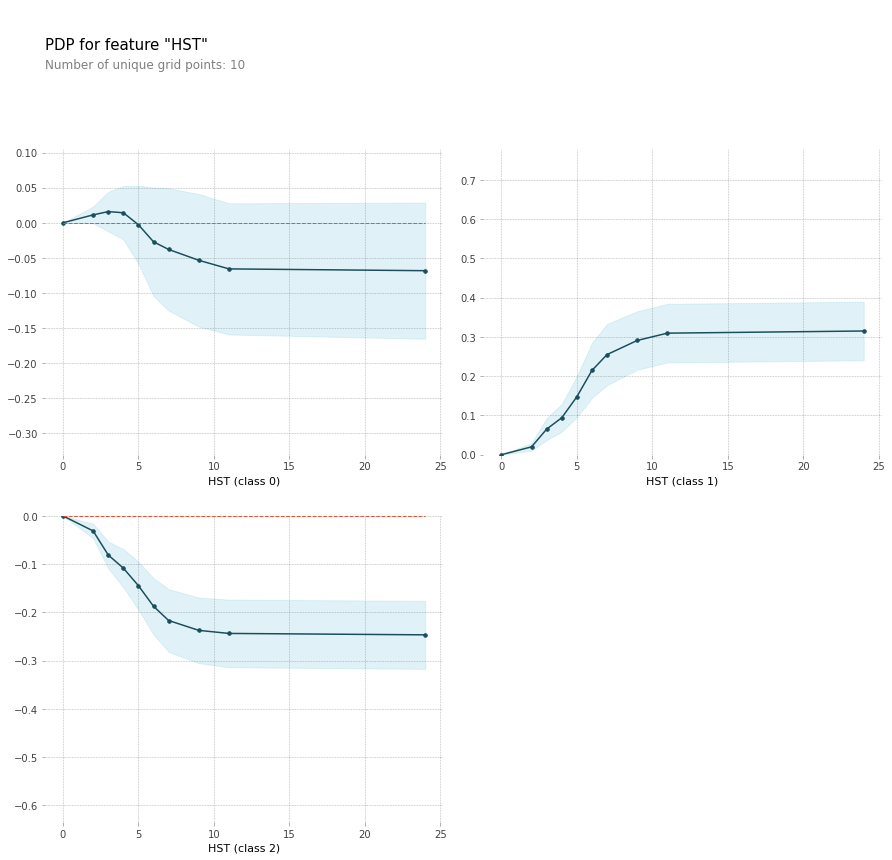

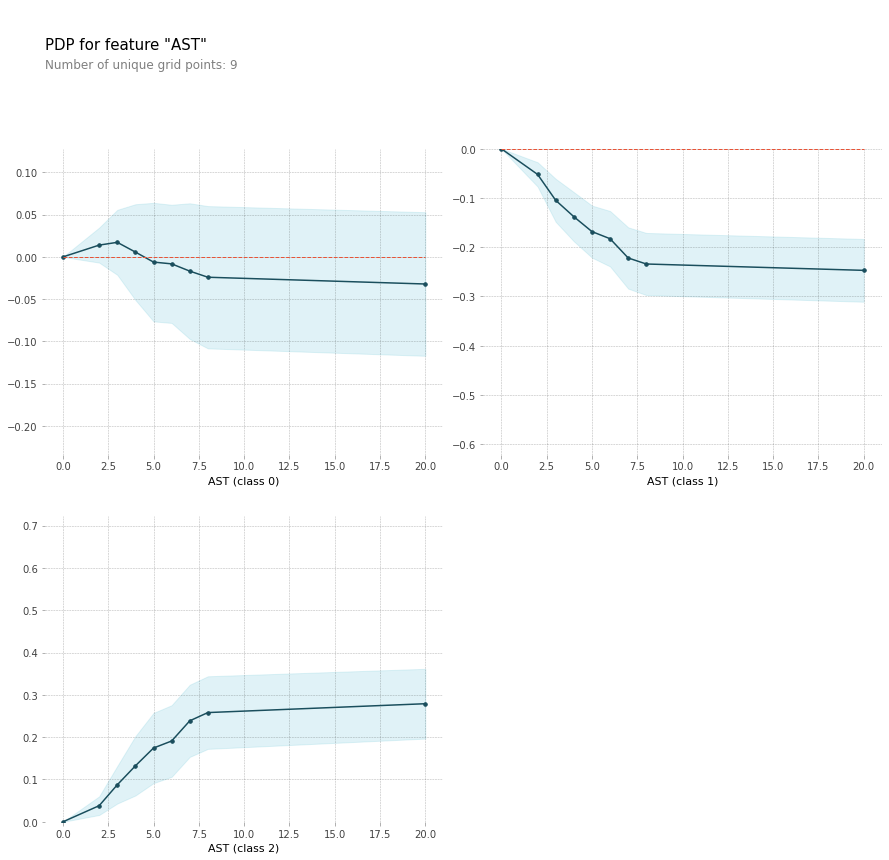

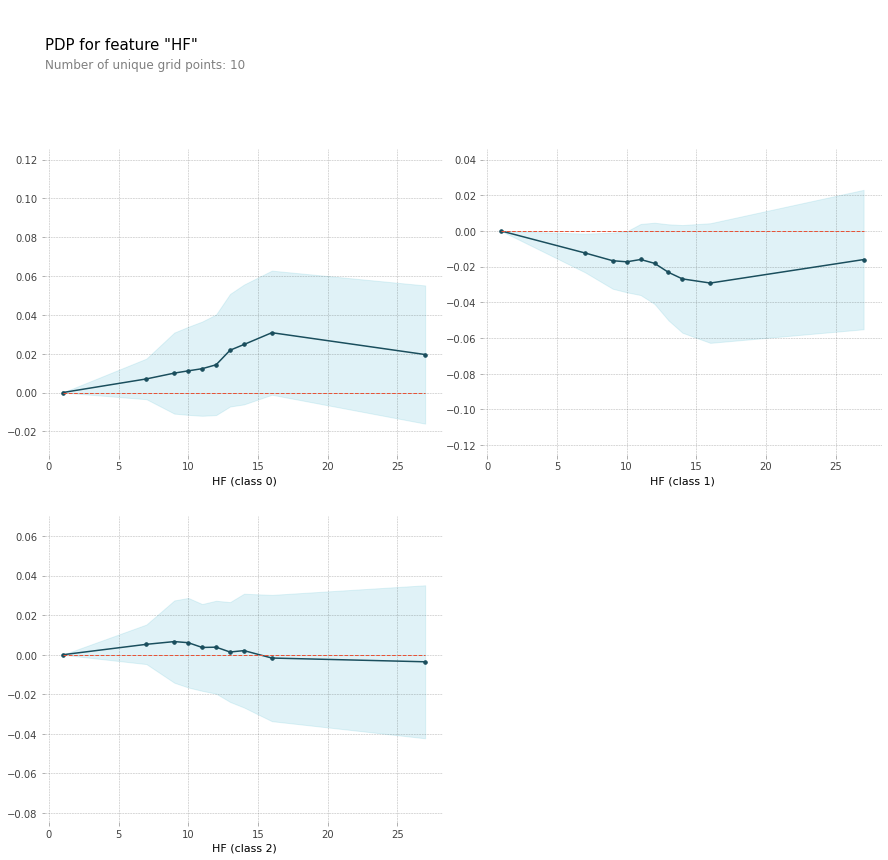

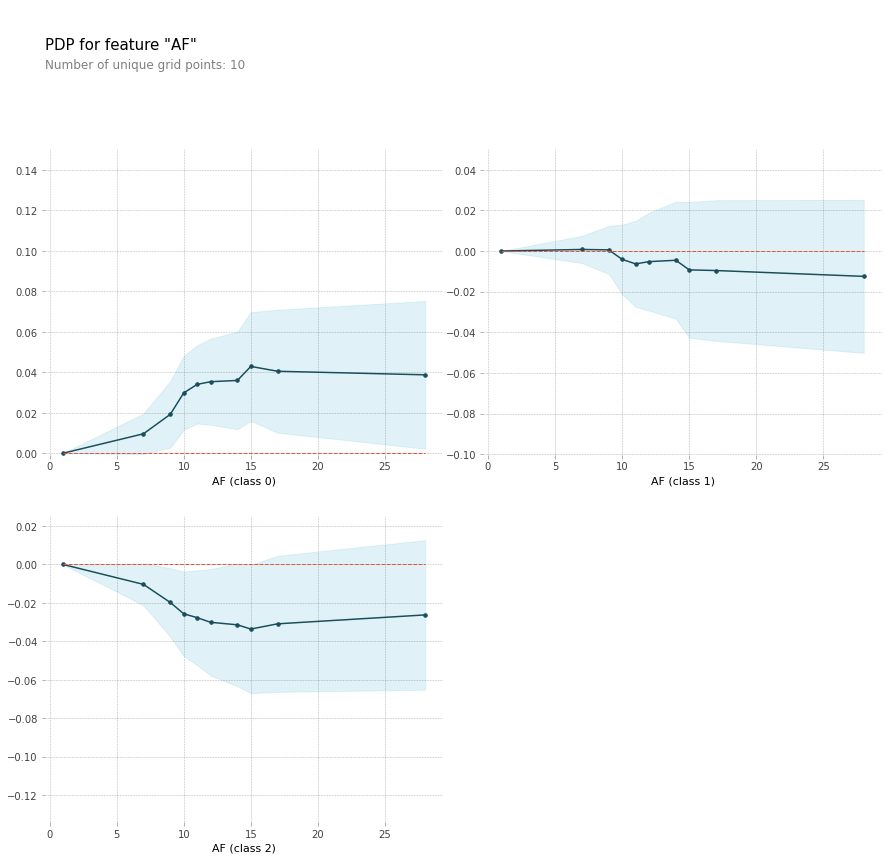

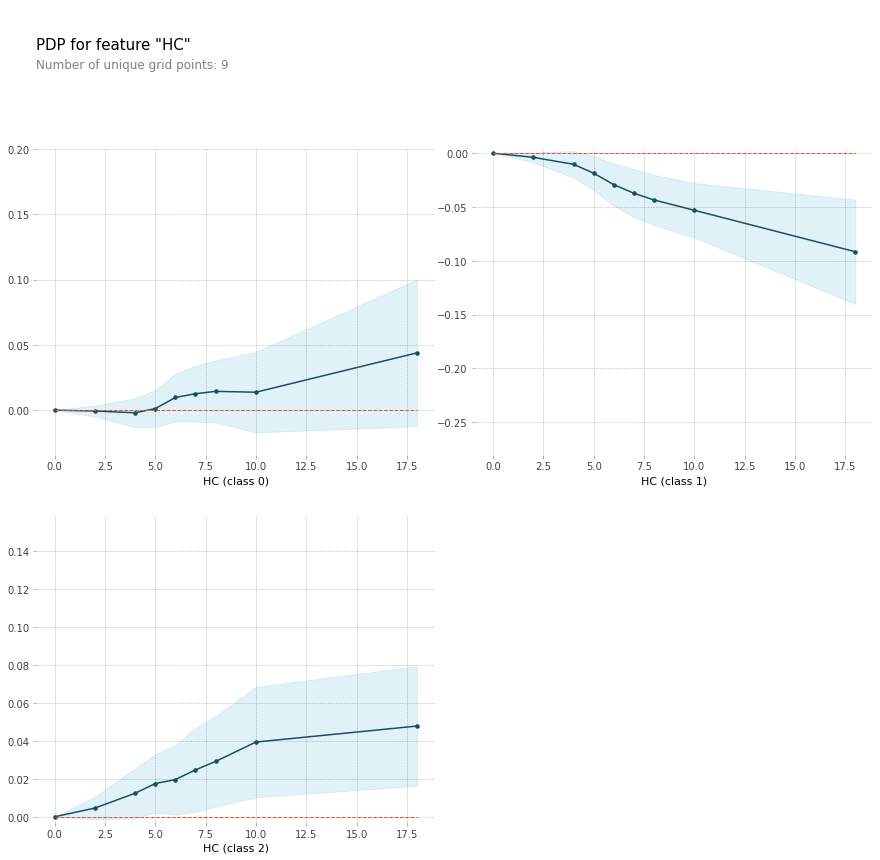

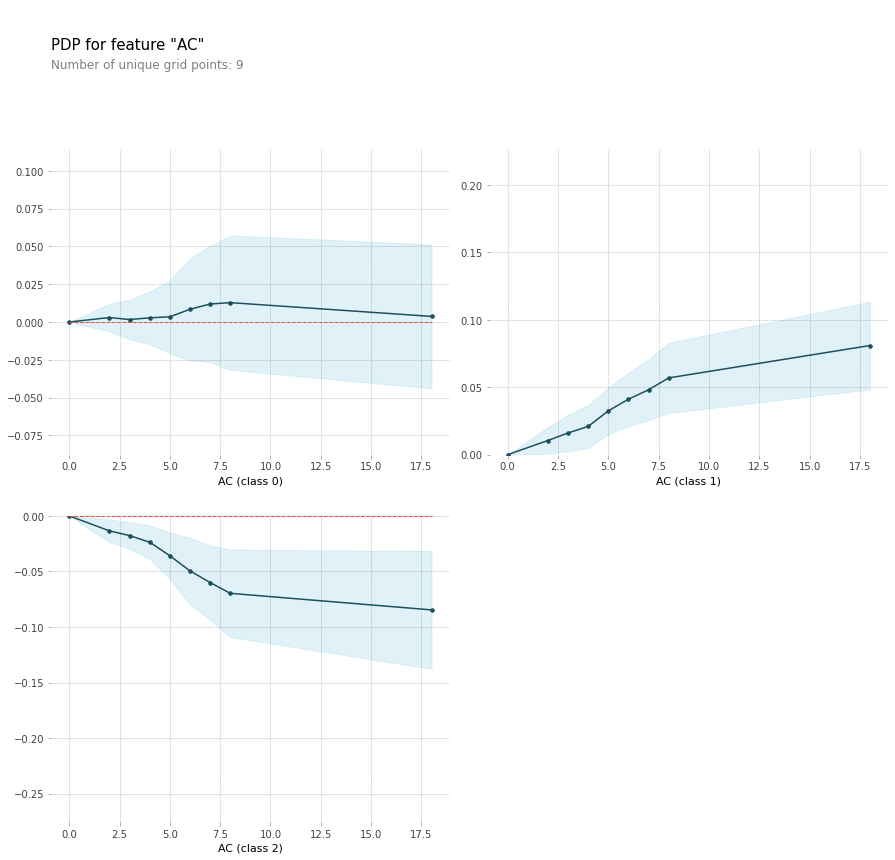

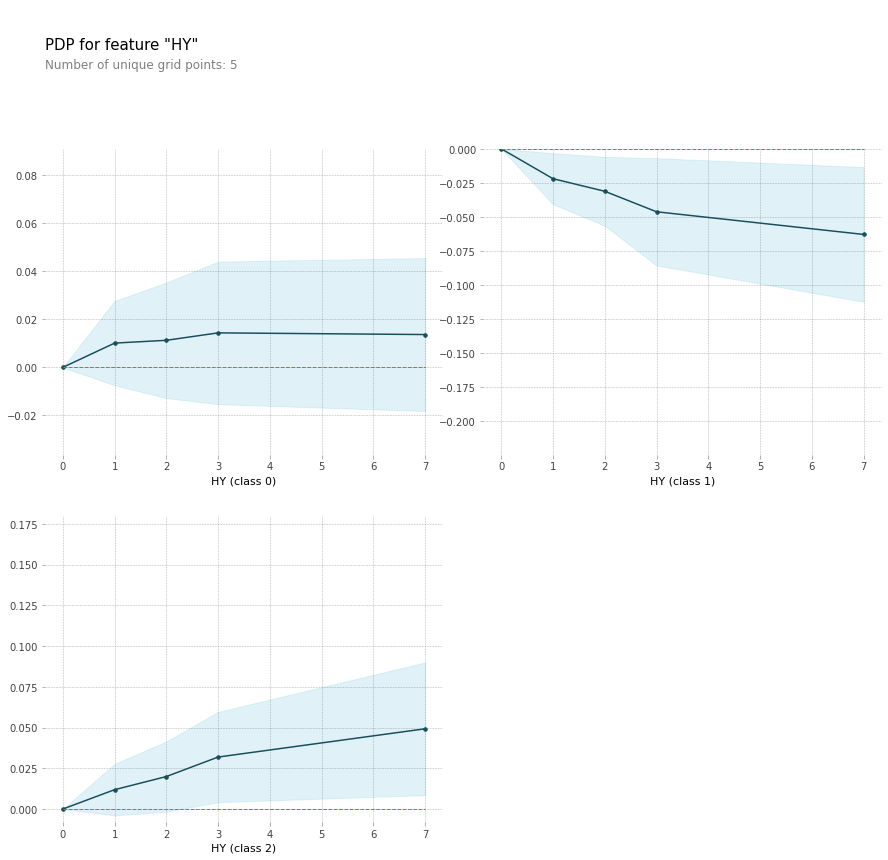

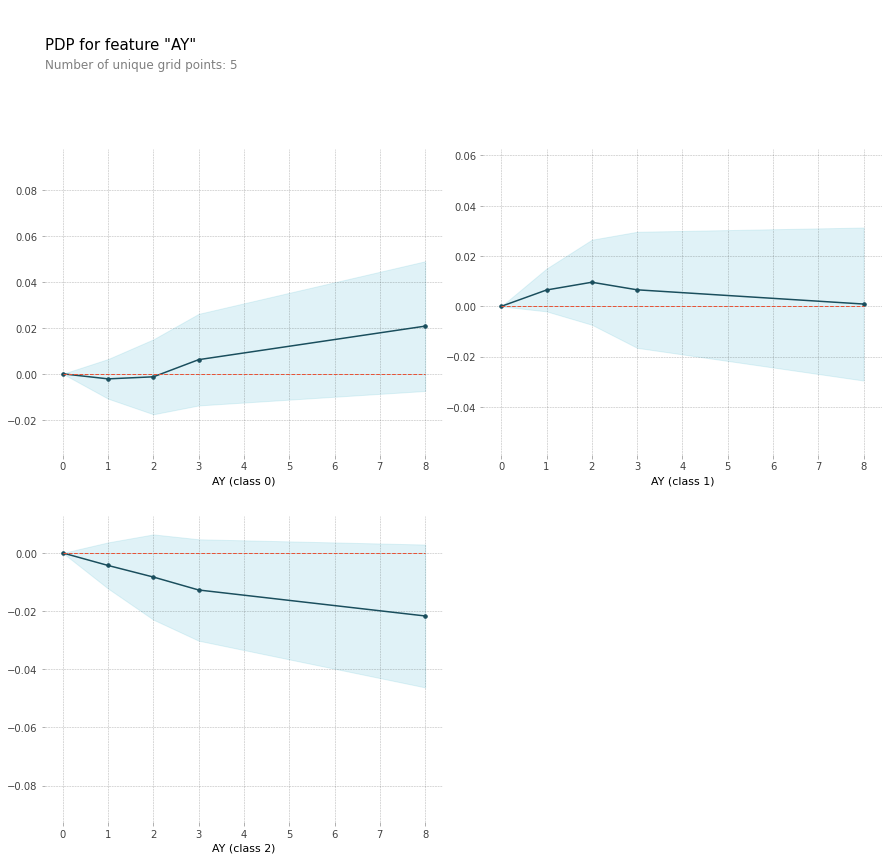

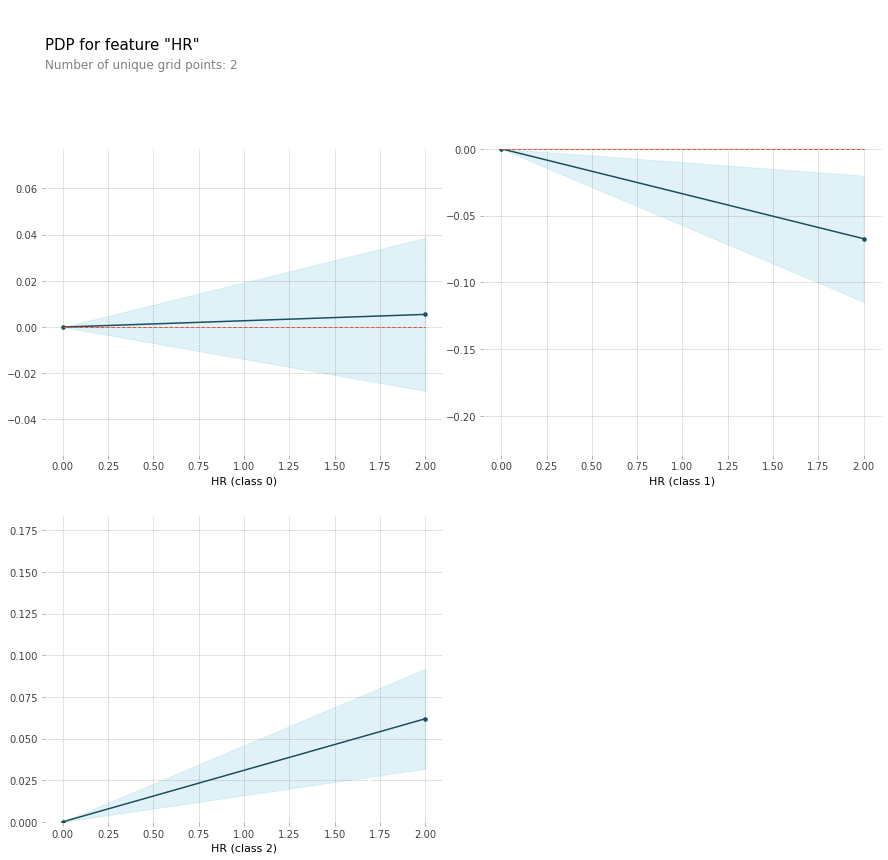

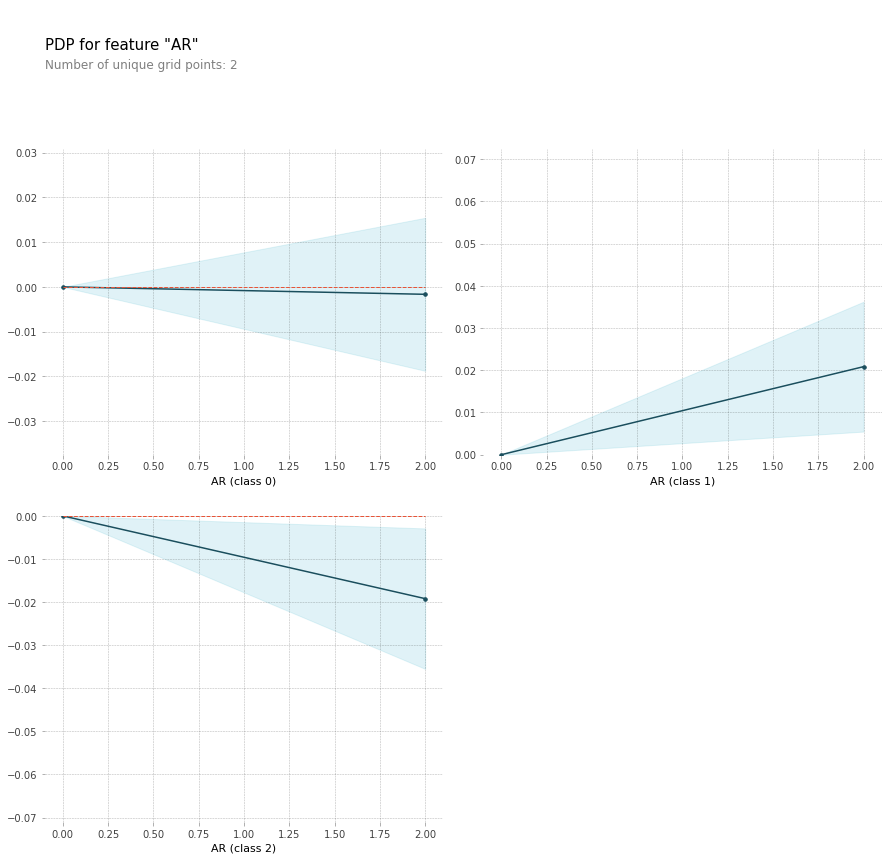

In [119]:
### 각 피처별로 PDP Plot 그리기
for col in list(X_val.columns):
  isolated = pdp_isolate(
      model=rfc_model,
      dataset=X_val,
      model_features=X_val.columns,
      feature=col
  )
  pdp_plot(isolated, feature_name=col);

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [ ]:
df.columns

In [158]:
features = ['HS', 'HST']
ord = OrdinalEncoder()
ord_X_val = ord.fit_transform(X_val)
interaction = pdp_interact(
    model=rfc_model, 
    dataset=ord_X_val,
    model_features=ord_X_val.columns, 
    features=features
)

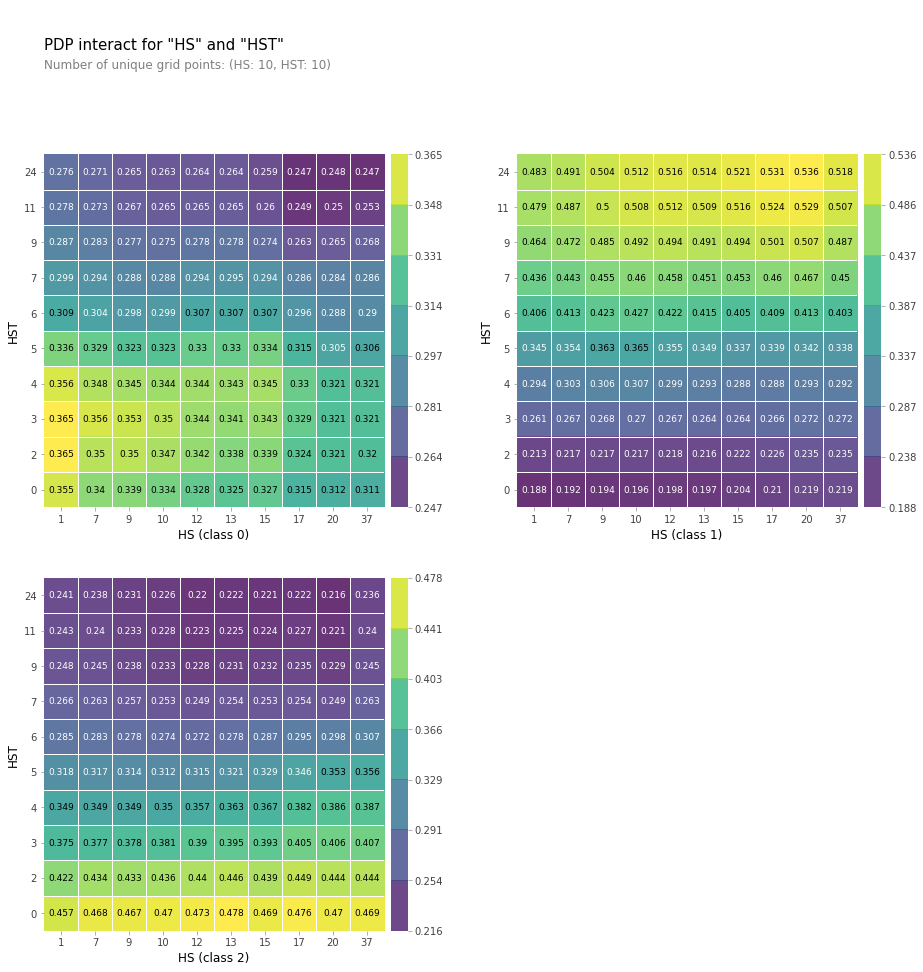

In [159]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [ ]:
! pip install shap

In [ ]:
ord_X_train = ord.transform(X_train)
rfc = RandomForestClassifier(
        n_estimators=1500,
        criterion='entropy',
        max_depth=None,
        min_samples_split=6,
        min_samples_leaf=5,
        random_state=7)

In [ ]:
rfc.fit(ord_X_train, y_train)

In [155]:
row = X_test.iloc[[3]] ### HT_rank : 1, AT_rank : 17
row = ord.transform(row)

    HomeTeam    AwayTeam  Referee  HS  AS  HST  AST  ...  AF  HC  AC  HY  AY  HR  AR
3  Leicester  Sunderland  L Mason  19  10    8    5  ...  17   6   3   2   4   0   0

[1 rows x 15 columns]


In [60]:
row

,HomeTeam,AwayTeam,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
3,39,30,25,19,10,8,5,13,17,6,3,2,4,0,0


In [ ]:
rfc.predict(row)

**승리/무승부/패배를 각각 shap로 그려서 해석하기**

In [ ]:
import shap

### 일반적인 경기
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    explainer.expected_value[1], 
    shap_values[1],
    row
)

In [128]:
a_red = (a['HR'] >= 1) | (a['AR'] >= 1)

In [129]:
a[a_red]

,HomeTeam,AwayTeam,Result,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
1,Chelsea,Swansea,0,M Oliver,11,18,3,10,15,16,4,8,1,3,1,0
13,Swansea,Newcastle,1,M Jones,19,4,6,2,11,8,4,4,2,1,0,1
16,West Ham,Leicester,2,A Taylor,10,11,3,6,11,12,8,4,1,3,1,0
25,West Ham,Bournemouth,2,J Moss,10,15,4,7,8,11,5,4,0,0,1,0
28,West Brom,Chelsea,2,M Clattenburg,15,15,6,5,9,12,8,7,2,1,0,1
33,Liverpool,West Ham,2,K Friend,13,12,1,5,17,11,5,7,3,1,1,1
35,Newcastle,Arsenal,2,A Marriner,1,22,0,9,15,8,0,9,6,1,1,0
36,Stoke,West Brom,2,M Oliver,13,15,5,5,4,9,6,5,1,4,2,0
38,Southampton,Norwich,1,J Moss,23,6,8,1,4,12,6,4,0,0,0,1
45,Watford,Swansea,1,R Madley,17,8,6,3,11,14,1,3,1,1,1,0


In [152]:
### 강팀(A)과 약팀(H)과의 경기에서 강팀이 퇴장이 나와서 약팀이 승리한 경우
new_row = X_test.iloc[[52]] ### HT_rank : 10, AT_rank : 2 
print(y_test.iloc[[52]])

new_row = ord.transform(new_row)

52    1
Name: Result, dtype: int64


In [153]:
rfc.predict(new_row)

array([1])

In [154]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(new_row)

shap.initjs()
shap.force_plot(
    explainer.expected_value[1], 
    shap_values[1],
    new_row
)

In [146]:
### 순위가 비슷한 팀
new_row2 = X_test.iloc[[257]]
print(y_test.iloc[[257]])

new_row2 = ord.transform(new_row2)

257    1
Name: Result, dtype: int64


In [147]:
rfc.predict(new_row2)

array([1])

In [148]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(new_row2)

shap.initjs()
shap.force_plot(
    explainer.expected_value[1], 
    shap_values[1],
    new_row2
)
### 순위가 비슷한 팀에서는 퇴장이 중요한 변수

**모델이 예측을 할 때 유효슈팅 특성과 팀 특성을 많이 고려했다.**

**추가적으로 점유율이나 패스의 수, 인터셉트의 수 같은 경기 결과를 더 자세하게 표현 해줄수있는 특성들이 예측에 도움을 줄 것 같다.**

**자세한 특성들은 공식 홈페이지를 구글링을 하거나 해외 데이터를 수집하는 사이트에 구매를 해야만 하는 것이 아쉽다.**

# 총평

**프로젝트를 진행하면서 더 자세한 데이터를 선정하지 못한 아쉬움이 많았다. 하이퍼파라미터 튜닝과 같이 머신러닝 기법이 숙달되지 않아서 모델의 성능이 높게 나오지 않았다.**

# 구단이 거둔 승리 나누기

**팀을 등급별로 나누면 사용**

In [ ]:
home = pd.DataFrame(df.groupby(['HomeTeam','Result'])['Result'].count())
home.rename(columns={'Result': 'Sum'}, inplace=True)
home = home.reset_index(drop=False)
home = home.drop(home[home['Result'] != 'H'].index) # 팀 별로 그 동안 홈에서 거둔 승리

In [ ]:
away = pd.DataFrame(df.groupby(['AwayTeam','Result'])['Result'].count())
away.rename(columns={'Result': 'Sum'}, inplace=True)
away = away.reset_index(drop=False)
away = away.drop(away[away['Result'] != 'A'].index) # 구단이 그 동안 원정에서 얻은 승리

In [ ]:
home.rename(columns={'HomeTeam': 'Team'}, inplace=True)
away.rename(columns={'AwayTeam': 'Team'}, inplace=True) # merge를 해주기 위해서 Team으로 바꿔줌

In [ ]:
total = pd.merge(home, away, on='Team')
total['Sum'] = total['Sum_x'] + total['Sum_y']
Total = total.loc[:, ['Team', 'Sum']]

In [ ]:
Total.sort_values(by='Sum', ascending=False) # 구단이 그 동안 홈과 원정에서 거둔 승리 합계

,Team,Sum
